In [61]:
import warnings

warnings.filterwarnings("ignore")
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [62]:
# Read Dataframe containing all the data
df = pd.read_pickle("../data/survey.pkl")

# Only take the base dataset data
df = df[df["dataset"] == "base"]

In [63]:
# Replace duration values over 60 with np.nan
df.loc[df.duration > 60, "duration"] = np.nan
# Clip Duration to 0-60
df["duration"] = df["duration"].clip(1, 60)

In [64]:
# Statistics of Base for Humans
human_df = df[df.model == "Human"]

print("Statistics of Base Dataset")
print(f" Num Users: {human_df.user_id.nunique()}")
print(f" Mean Duration: {human_df.duration.mean()}")
print(f" Median Duration: {human_df.duration.median()}")

Statistics of Base Dataset
 Num Users: 60
 Mean Duration: 10.706250633981403
 Median Duration: 8.0


In [65]:
# HUMAN ACCURACY and CERTAINTY for BASE DATASET - Per User
dfh = df[df.model == "Human"]
# Accuracy
accs = dfh.groupby("user_id").apply(lambda x: np.sum(x.prediction == x["label"]) / len(x)).rename("accuracy")

# Mean Certainty
cert = dfh.groupby("user_id").apply(lambda x: np.mean(x.certainty)).rename("certainty")

# Mean Certainty for Imposters
cert_imposter = dfh[(~df.label)].groupby("user_id").apply(lambda x: np.mean(x.certainty)).rename("certainty_imposter")

# Mean Accuracy for Imposters
acc_imposter = dfh[(~df.label)].groupby("user_id").apply(lambda x: np.sum(x.prediction == x.label) / len(x)).rename("accuracy_imposter")

# Mean Certainty for Genuine
cert_genuine = dfh[(df.label)].groupby("user_id").apply(lambda x: np.mean(x.certainty)).rename("certainty_genuine")

# Mean Accuracy for Genuine
acc_genuine = dfh[(df.label)].groupby("user_id").apply(lambda x: np.sum(x.prediction == x.label) / len(x)).rename("accuracy_genuine")

# Mean Certainty for Wrong Predictions
cert_wrong = dfh[(df.prediction != df.label)].groupby("user_id").apply(lambda x: np.mean(x.certainty)).rename("certainty_wrong")

# Mean Accuracy for Wrong Predictions
acc_wrong = (
    dfh[(df.prediction != df.label)].groupby("user_id").apply(lambda x: np.sum(x.prediction == x.label) / len(x)).rename("accuracy_wrong")
)

# Mean Certainty for Correct Predictions
cert_correct = dfh[(df.prediction == df.label)].groupby("user_id").apply(lambda x: np.mean(x.certainty)).rename("certainty_correct")

# Mean Accuracy for Correct Predictions
acc_correct = (
    dfh[(df.prediction == df.label)].groupby("user_id").apply(lambda x: np.sum(x.prediction == x.label) / len(x)).rename("accuracy_correct")
)

# Print Results
result = pd.concat(
    [accs, cert, acc_imposter, acc_genuine, cert_imposter, cert_genuine, acc_wrong, acc_correct, cert_wrong, cert_correct], axis=1
)
print(result.to_markdown(floatfmt=".2%"))

|   user_id |   accuracy |   certainty |   accuracy_imposter |   accuracy_genuine |   certainty_imposter |   certainty_genuine |   accuracy_wrong |   accuracy_correct |   certainty_wrong |   certainty_correct |
|----------:|-----------:|------------:|--------------------:|-------------------:|---------------------:|--------------------:|-----------------:|-------------------:|------------------:|--------------------:|
|         1 |     52.50% |      68.75% |              95.00% |             10.00% |               69.20% |              68.30% |            0.00% |            100.00% |            67.95% |              69.48% |
|         2 |     85.00% |      46.10% |              90.00% |             80.00% |               52.00% |              40.20% |            0.00% |            100.00% |            33.00% |              48.41% |
|         3 |     70.00% |      62.22% |              70.00% |             70.00% |               66.15% |              58.30% |            0.00% |         

Mean Accuracy: 67.25% (STD: 8.53%, MAX: 90.00%, MIN: 50.00%)
Mean Certainty: 59.66% (STD: 14.61%, MAX: 93.55%, MIN: 28.20%)
Mean Accuracy Genuine Pairs: 51.17% (STD: 17.84%, MAX: 90.00%, MIN: 10.00%)
Mean Certainty Genuine Pairs: 54.83% (STD: 16.28%, MAX: 94.60%, MIN: 24.15%)
Mean Accuracy Imposter Pairs: 83.33% (STD: 11.49%, MAX: 100.00%, MIN: 50.00%)
Mean Certainty Imposter Pairs: 64.49% STD(14.57%), MAX: 97.60%, MIN: 32.25%)


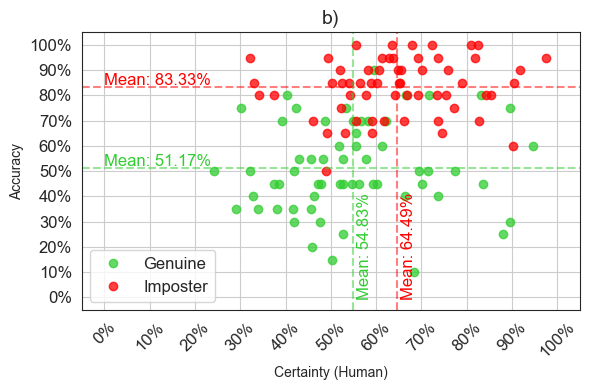

In [66]:
# Plot Accuracy vs Certainty
plt.figure(figsize=(6, 4))
plt.plot(cert_genuine, acc_genuine, ".", markersize=12, alpha=0.75, color="limegreen")
plt.plot(cert_imposter, acc_imposter, ".", markersize=12, alpha=0.75, color="red")
plt.legend(["Genuine", "Imposter"], loc="lower left", fontsize=12)
plt.xticks(np.linspace(0, 1, 11), [f"{val:.0%}" for val in np.linspace(0, 1, 11)], fontsize=12, rotation=45)
plt.yticks(np.linspace(0, 1, 11), [f"{val:.0%}" for val in np.linspace(0, 1, 11)], fontsize=12)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("Certainty (Human)")
plt.ylabel("Accuracy")
plt.grid("on")

# Add mean line for each group vertically and horizontally
plt.axvline(cert_genuine.mean(), color="limegreen", linestyle="--", alpha=0.5)
plt.axhline(acc_genuine.mean(), color="limegreen", linestyle="--", alpha=0.5)
plt.axvline(cert_imposter.mean(), color="red", linestyle="--", alpha=0.5)
plt.axhline(acc_imposter.mean(), color="red", linestyle="--", alpha=0.5)

# Add a text to each line for explanation
plt.text(0, acc_genuine.mean() + 0.01, f"Mean: {acc_genuine.mean():.2%}", color="limegreen", fontsize=12)
plt.text(0, acc_imposter.mean() + 0.01, f"Mean: {acc_imposter.mean():.2%}", color="red", fontsize=12)

plt.text(cert_genuine.mean() + 0.01, 0, f"Mean: {cert_genuine.mean():.2%}", color="limegreen", fontsize=12, rotation=90)
plt.text(cert_imposter.mean() + 0.01, 0, f"Mean: {cert_imposter.mean():.2%}", color="red", fontsize=12, rotation=90)

# Set title
plt.title("b)", fontsize=14)
plt.tight_layout()

plt.savefig("../figures/accuracy_certainty_gen_imposter.pdf", bbox_inches="tight")

# Print Mean Std Max and Min Values
print(f"Mean Accuracy: {accs.mean():.2%} (STD: {accs.std():.2%}, MAX: {accs.max():.2%}, MIN: {accs.min():.2%})")
print(f"Mean Certainty: {cert.mean():.2%} (STD: {cert.std():.2%}, MAX: {cert.max():.2%}, MIN: {cert.min():.2%})")
print(
    f"Mean Accuracy Genuine Pairs: {acc_genuine.mean():.2%} (STD: {acc_genuine.std():.2%}, MAX: {acc_genuine.max():.2%}, MIN: {acc_genuine.min():.2%})"
)
print(
    f"Mean Certainty Genuine Pairs: {cert_genuine.mean():.2%} (STD: {cert_genuine.std():.2%}, MAX: {cert_genuine.max():.2%}, MIN: {cert_genuine.min():.2%})"
)
print(
    f"Mean Accuracy Imposter Pairs: {acc_imposter.mean():.2%} (STD: {acc_imposter.std():.2%}, MAX: {acc_imposter.max():.2%}, MIN: {acc_imposter.min():.2%})"
)
print(
    f"Mean Certainty Imposter Pairs: {cert_imposter.mean():.2%} STD({cert_imposter.std():.2%}), MAX: {cert_imposter.max():.2%}, MIN: {cert_imposter.min():.2%})"
)

In [67]:
# Calculate Mean and Std of certainty for each pair_id
certainty = dfh.groupby(["pair_id"]).certainty.agg(["mean", "std"]).reset_index()
accuracy = dfh.groupby(["pair_id"]).correct.agg(["mean", "std"]).reset_index()

# Merge the two dataframes
result = pd.merge(certainty, accuracy, on="pair_id", how="inner", suffixes=("_certainty", "_accuracy"))
result.pair_id = result.pair_id.astype(str)

# Print Results
print(result.to_markdown(floatfmt=".2%"))

|    |   pair_id |   mean_certainty |   std_certainty |   mean_accuracy |   std_accuracy |
|---:|----------:|-----------------:|----------------:|----------------:|---------------:|
|  0 |        65 |           52.48% |          27.37% |          50.00% |         50.42% |
|  1 |       122 |           59.05% |          26.93% |          65.00% |         48.10% |
|  2 |       320 |           52.78% |          27.10% |          56.67% |         49.97% |
|  3 |       332 |           75.40% |          23.54% |          88.33% |         32.37% |
|  4 |       534 |           67.72% |          22.49% |          86.67% |         34.28% |
|  5 |       568 |           77.87% |          22.06% |          96.67% |         18.10% |
|  6 |       674 |           38.82% |          30.14% |          61.67% |         49.03% |
|  7 |       721 |           59.33% |          26.42% |          30.00% |         46.21% |
|  8 |       731 |           66.75% |          24.66% |          40.00% |         49.40% |

In [68]:
# Correlation between Accuracy and Certainty
print(f"Correlation between Accuracy and Certainty: {result['mean_accuracy'].corr(result['mean_certainty']):.2f}")

# Correlation between Accuracy and Accuracy STD
print(f"Correlation between Accuracy and Accuracy STD: {result['mean_accuracy'].corr(result['std_accuracy']):.2f}")

# Correlation between Certainty and Certainty STD
print(f"Correlation between Certainty and Certainty STD: {result['mean_certainty'].corr(result['std_certainty']):.2f}")

Correlation between Accuracy and Certainty: 0.44
Correlation between Accuracy and Accuracy STD: -0.75
Correlation between Certainty and Certainty STD: -0.78


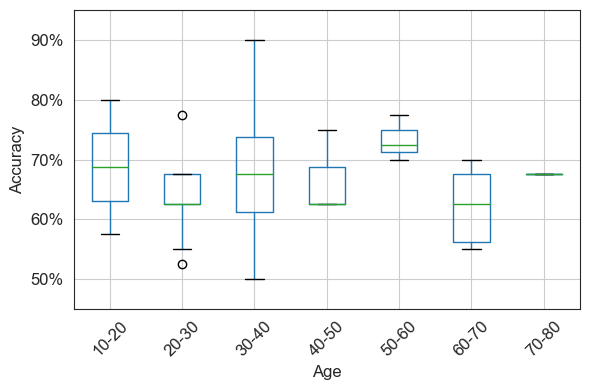

In [69]:
# Make Boxplot for Accuracy dependig on Age
df_u = pd.read_pickle("../data/user.pkl")
df_u.rename(columns={"id": "user_id"}, inplace=True)

df_join = pd.merge(df_u, dfh, on="user_id", how="inner")

# Make bins of age and group user_ids
bins = pd.cut(df_join.age, bins=[10, 20, 30, 40, 50, 60, 70, 80], labels=["10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"])

df_join.pivot_table(index="user_id", columns=bins, values="correct", aggfunc=("mean")).boxplot(figsize=(6, 4), rot=45, fontsize=12)
plt.xlabel("Age", fontsize=12)

# yaxis in percent
plt.yticks(np.linspace(0, 1, 11), [f"{val:.0%}" for val in np.linspace(0, 1, 11)], fontsize=12)

# ylim
plt.ylim(0.45, 0.95)

plt.ylabel("Accuracy", fontsize=12)
plt.grid("on")
plt.tight_layout()

plt.savefig("../figures/accuracy_age_boxplot.pdf", bbox_inches="tight")

In [70]:
# Read in user data
df_u = pd.read_pickle("../data/user.pkl")
df_u.rename(columns={"id": "user_id"}, inplace=True)

df_join = pd.merge(df_u, dfh, on="user_id", how="inner")

# Make bins of age and group user_ids
bins = pd.cut(df_join.age, bins=[10, 20, 30, 40, 50, 60, 70, 80], labels=["10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80"])

result = df_join.groupby(bins)["correct"].apply(lambda x: x.sum() / len(x)).reset_index(name="accuracy")

# add the count of users in each age bin
result["count"] = df_join.groupby(bins)["user_id"].nunique().values

# Print
print(result.to_markdown(floatfmt=".2%"))

|    | age   |   accuracy |   count |
|---:|:------|-----------:|--------:|
|  0 | 10-20 |     68.75% |       2 |
|  1 | 20-30 |     63.89% |       9 |
|  2 | 30-40 |     67.90% |      31 |
|  3 | 40-50 |     66.67% |       3 |
|  4 | 50-60 |     73.33% |       3 |
|  5 | 60-70 |     62.14% |       7 |
|  6 | 70-80 |     67.50% |       1 |


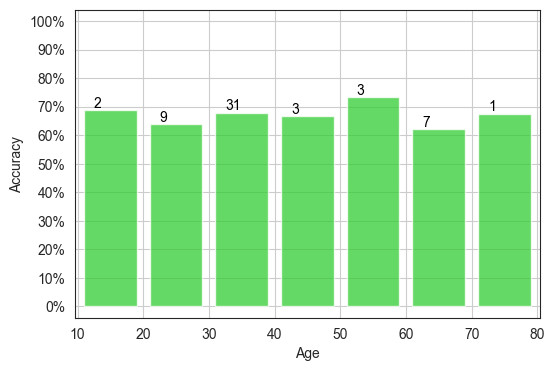

In [71]:
# Visualize the age vs accuracy as Boxplots
plt.figure(figsize=(6, 4))
plt.bar(np.arange(0, len(result.accuracy)), result.accuracy, alpha=0.75, color="limegreen")
plt.xlabel("Age")
plt.ylabel("Accuracy")
plt.xticks(np.arange(-0.5, len(result.accuracy) + 0.5), np.arange(10, 90, 10))
plt.yticks(np.linspace(0, 1, 11), [f"{x:.0%}" for x in np.linspace(0, 1, 11)])
plt.xlim(-0.54, 6.54)
plt.ylim(-0.04, 1.04)
plt.grid("on")

# Write count numbers on top of bars
for i, v in enumerate(result.accuracy):
    plt.text(i - 0.25, v + 0.01, result["count"][i], color="black")

plt.savefig("../figures/accuracy_age.pdf", bbox_inches="tight")

In [72]:
# Get answers of first pair_id
dfh.pivot(index="user_id", columns="pair_id", values="correct")

pair_id,65,122,320,332,534,568,674,721,731,1179,...,4218,4737,4781,4871,4951,5028,5275,5302,5543,5600
user_id,,,,,,,,,,,,,,,,,,,,,
1,False,False,True,True,True,True,False,False,False,True,...,False,True,True,True,False,False,True,False,False,False
2,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,False,False,True,True,True,True
3,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,False,True,False,True
4,False,False,True,True,True,True,True,False,False,True,...,True,False,True,True,False,True,False,True,False,True
5,True,True,False,True,True,True,True,False,True,True,...,True,False,True,True,True,False,False,True,False,True
6,True,True,False,True,True,True,True,True,True,True,...,True,True,True,True,False,False,True,False,True,True
7,True,False,True,True,True,True,False,False,False,True,...,True,True,True,True,False,False,True,True,False,True
8,False,True,True,True,True,True,False,False,False,True,...,True,True,True,False,False,False,True,True,False,False
9,True,False,False,False,True,True,True,False,True,True,...,True,False,False,True,True,False,False,False,True,False


In [73]:
# Calculate the mean certainty for true positives
cert_tp = dfh[(dfh.prediction == True) & (dfh.label == True)].certainty

# Calculate the mean certainty for false positives
cert_fp = dfh[(dfh.prediction == True) & (dfh.label == False)].certainty

# Calculate the mean certainty for true negatives
cert_tn = dfh[(dfh.prediction == False) & (dfh.label == False)].certainty

# Calculate the mean certainty for false negatives
cert_fn = dfh[(dfh.prediction == False) & (dfh.label == True)].certainty

# Print Results
print(f"Mean Certainty for TP: {cert_tp.mean():.2%} (Std: {cert_tp.std():.2%})")
print(f"Mean Certainty for FP: {cert_fp.mean():.2%} (Std: {cert_fp.std():.2%})")
print(f"Mean Certainty for TN: {cert_tn.mean():.2%} (Std: {cert_tn.std():.2%})")
print(f"Mean Certainty for FN: {cert_fn.mean():.2%} (Std: {cert_fn.std():.2%})")

Mean Certainty for TP: 56.73% (Std: 27.74%)
Mean Certainty for FP: 55.63% (Std: 25.73%)
Mean Certainty for TN: 66.27% (Std: 28.94%)
Mean Certainty for FN: 52.83% (Std: 30.33%)


Human Accuracy: 85.00% (Std: 36.16%)
Machine Accuracy: 67.25% (Std: 46.94%)


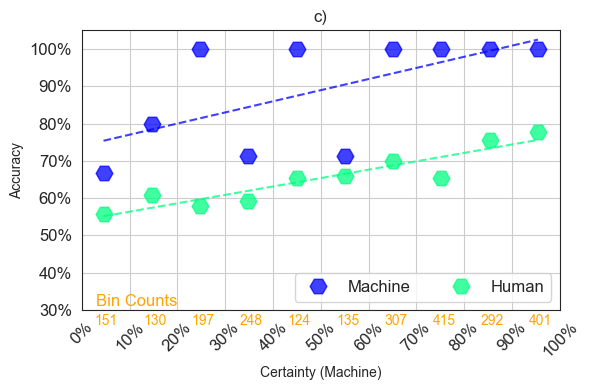

In [74]:
mymodel = "AIMean"

mydf = df[(df.model.isin([mymodel, "Human"]))]


# Plot Accuracy vs Certainty
NUM_BINS = 10
# define the bins based on the values in the first column
bins = pd.cut(mydf.certainty, bins=np.linspace(-0.001, 1.0, NUM_BINS + 1))

# group the data by the bins and calculate the percentage of True values in col2 within each bin
accs = mydf.groupby(["model", bins])["correct"].apply(lambda x: x.sum() / len(x)).reset_index(name="accuracy")
cnts = mydf.groupby(["model", bins])["correct"].count().reset_index(name="counts")

colors = cm.winter(np.linspace(0, 1, len(accs.model.unique())))


plt.figure(figsize=(6, 4))
for i2, model in enumerate(accs.model.unique()):
    plt.plot(
        np.linspace(0.0, 1.0, len(accs.certainty.unique())),
        accs[accs.model == model].accuracy,
        "H",
        markersize=12,
        alpha=0.75,
        color=colors[i2],
    )
    # Add text to the plot with counts for each bin
    if model == "Human":
        for i, _ in enumerate(accs.certainty.unique()):
            plt.text(
                np.linspace(0.0, 1.0, len(accs.certainty.unique()))[i] - 0.02,
                0.26,
                cnts[cnts.model == model].counts.values[i],
                color="orange",
                fontsize=10,
            )
plt.legend(["Machine", "Human"], fontsize=12, loc="lower right", ncols=2)
plt.xlim(-0.05, 1.05)
plt.ylim(0.3, 1.05)
plt.xticks(
    np.linspace(-0.05, 1.05, len(accs.certainty.unique()) + 1),
    [f"{val:.0%}" for val in np.linspace(0.0, 1.0, len(accs.certainty.unique()) + 1)],
    fontsize=12,
    rotation=45,
)
plt.yticks(np.linspace(0.3, 1, 8), [f"{val:.0%}" for val in np.linspace(0.3, 1, 8)], fontsize=12)
plt.xlabel("Certainty (Machine)")
plt.ylabel("Accuracy")
plt.title("c)")

# Make a text in orange with "Bin Counts"
plt.text(-0.017, 0.31, "Bin Counts", color="orange", fontsize=12)

# Add trendline for both models
for i2, model in enumerate(accs.model.unique()):
    z = np.polyfit(np.linspace(0.0, 1.0, len(accs.certainty.unique())), accs[accs.model == model].accuracy, 1)
    p = np.poly1d(z)
    plt.plot(
        np.linspace(0.0, 1.0, len(accs.certainty.unique())),
        p(np.linspace(0.0, 1.0, len(accs.certainty.unique()))),
        color=colors[i2],
        alpha=0.75,
        linestyle="--",
        linewidth=1.5,
    )

plt.grid("on")
plt.tight_layout()

plt.savefig("../figures/base_acc_vs_cert.pdf", bbox_inches="tight")

# Print Human vs Machine Accuracy
print(f"Human Accuracy: {mydf[mydf.model == mymodel].correct.mean():.2%} (Std: {mydf[mydf.model == mymodel].correct.std():.2%})")
print(f"Machine Accuracy: {mydf[mydf.model == 'Human'].correct.mean():.2%} (Std: {mydf[mydf.model == 'Human'].correct.std():.2%})")

In [75]:
# MACHINE ACCURACY and CERTAINTY for BASE DATASET

# Accuracy
acc = pd.DataFrame(df.groupby("model").apply(lambda x: np.sum(x.prediction == x.label) / len(x.label)), columns=["accuracy"])

# Mean Certainty
cert = pd.DataFrame(df.groupby("model").apply(lambda x: np.mean(x.certainty)), columns=["certainty"])

# Mean Certainty of only imposter pairs
cert_imposter = pd.DataFrame(df[(~df.label)].groupby("model").apply(lambda x: np.mean(x.certainty)), columns=["certainty_imposter"])

# Mean Certainty of only genuine pairs
cert_genuine = pd.DataFrame(df[(df.label)].groupby("model").apply(lambda x: np.mean(x.certainty)), columns=["certainty_genuine"])

# Mean Certainty of only wrong predictions
cert_wrong = pd.DataFrame(
    df[(df.prediction != df.label)].groupby("model").apply(lambda x: np.mean(x.certainty)), columns=["certainty_wrong"]
)

# Mean Certainty of only correct predictions
cert_correct = pd.DataFrame(
    df[(df.prediction == df.label)].groupby("model").apply(lambda x: np.mean(x.certainty)), columns=["certainty_correct"]
)

# Join the results
result = pd.concat([acc, cert, cert_imposter, cert_genuine, cert_wrong, cert_correct], axis=1)


# Print the results
print(result.to_markdown(floatfmt=".2%"))
print(result.mean().rename("average").to_markdown(floatfmt=".2%"))

| model      |   accuracy |   certainty |   certainty_imposter |   certainty_genuine |   certainty_wrong |   certainty_correct |
|:-----------|-----------:|------------:|---------------------:|--------------------:|------------------:|--------------------:|
| AIMax      |     85.00% |      76.26% |               78.95% |              73.57% |            63.69% |              78.48% |
| AIMean     |     85.00% |      52.39% |               51.94% |              52.85% |            35.10% |              55.45% |
| AIMin      |     75.00% |      26.53% |               25.87% |              27.19% |             6.53% |              33.19% |
| ArcFace*   |     67.50% |      39.79% |               40.03% |              39.55% |            25.46% |              46.69% |
| FaceTrans* |     82.50% |      52.31% |               47.66% |              56.95% |            23.06% |              58.51% |
| Human      |     67.25% |      59.66% |               64.49% |              54.83% |           

Mean: 0.60
Std: 0.30


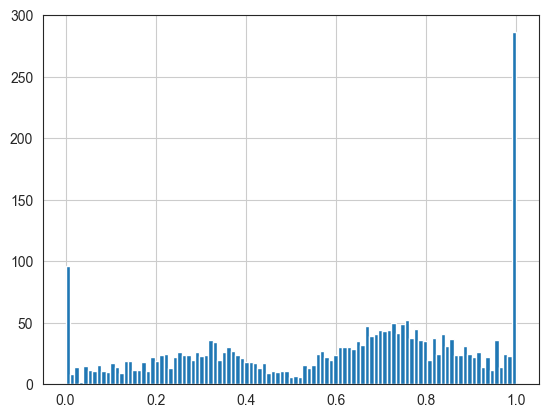

In [76]:
# Visualize Distribution of Confidence for each User on Base Dataset
# Note that certainty is a value between 0 and 100 -> 101 different possible values
df[df.dataset == "base"].certainty.hist(bins=101)
print(f"Mean: {df[df.dataset == 'base'].certainty.mean():.02f}")
print(f"Std: {df[df.dataset == 'base'].certainty.std():.02f}")

<Axes: >

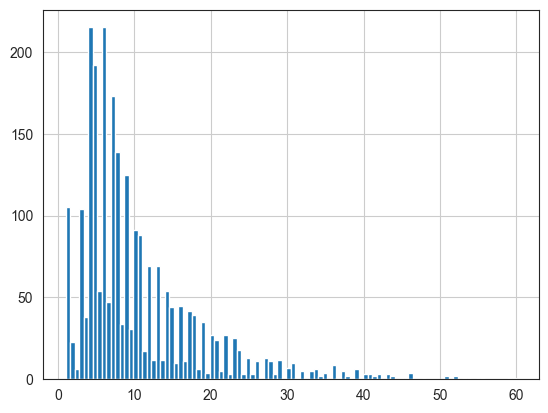

In [77]:
# Show Histogram of Durations
df.duration.clip(upper=100).hist(bins=100)

In [78]:
# FUSION of Human-Machine with different Fusion Algorithms

tmp = []
for model in ["ArcFace", "FaceTrans", "ProdPoly"]:
    # Max of HumanMean and Machine
    a = pd.DataFrame(
        df[(df.model == "HumanMean") | (df.model == model)]
        .groupby(["pair_id"])
        .apply(lambda x: x[x.certainty == x.certainty.max()]["weighted_prediction"].values[0]),
        columns=["weighted_prediction"],
    ).reset_index()
    a["algo"] = "Max"
    a["model"] = "HumanMean"
    a["fusion_model"] = model

    # Max of HumanMax and Machine
    b = pd.DataFrame(
        df[(df.model == "HumanMax") | (df.model == model)]
        .groupby("pair_id")
        .apply(lambda x: x[x.certainty == x.certainty.max()]["weighted_prediction"].values[0]),
        columns=["weighted_prediction"],
    ).reset_index()
    b["algo"] = "Max"
    b["model"] = "HumanMax"
    b["fusion_model"] = model

    # Mean of HumanMean and Machine
    c = pd.DataFrame(
        (df[(df.model == "HumanMean") | (df.model == model)].groupby(["pair_id"]).apply(lambda x: x.weighted_prediction_num.mean()) > 0),
        columns=["weighted_prediction"],
    ).reset_index()
    c["algo"] = "Mean"
    c["model"] = "HumanMean"
    c["fusion_model"] = model

    # Mean of HumanMax and Machine
    d = pd.DataFrame(
        (df[(df.model == "HumanMax") | (df.model == model)].groupby("pair_id").apply(lambda x: x.weighted_prediction_num.mean()) > 0),
        columns=["weighted_prediction"],
    ).reset_index()
    d["algo"] = "Mean"
    d["model"] = "HumanMax"
    d["fusion_model"] = model

    e = pd.concat([a, b, c, d], ignore_index=True)
    tmp.append(e)

result = pd.concat(tmp, ignore_index=True).merge(df[["pair_id", "label"]].drop_duplicates(), on="pair_id", how="left")

# Print Results
print(
    result.groupby(["algo", "model", "fusion_model"])
    .apply(lambda x: np.sum(x.weighted_prediction == x.label) / len(x))
    .rename("accuracy")
    .unstack()
    .to_markdown(floatfmt=".2%")
)

|                       |   ArcFace |   FaceTrans |   ProdPoly |
|:----------------------|----------:|------------:|-----------:|
| ('Max', 'HumanMax')   |    70.00% |      70.00% |     72.50% |
| ('Max', 'HumanMean')  |     0.00% |       0.00% |     57.50% |
| ('Mean', 'HumanMax')  |    70.00% |      70.00% |     70.00% |
| ('Mean', 'HumanMean') |    70.00% |      70.00% |     77.50% |


In [79]:
# Make stats for certainty per user and std mean etc. correlation of right and wrong with certainty etc. Range of certainty. Same Question different users, how large is std here etc.

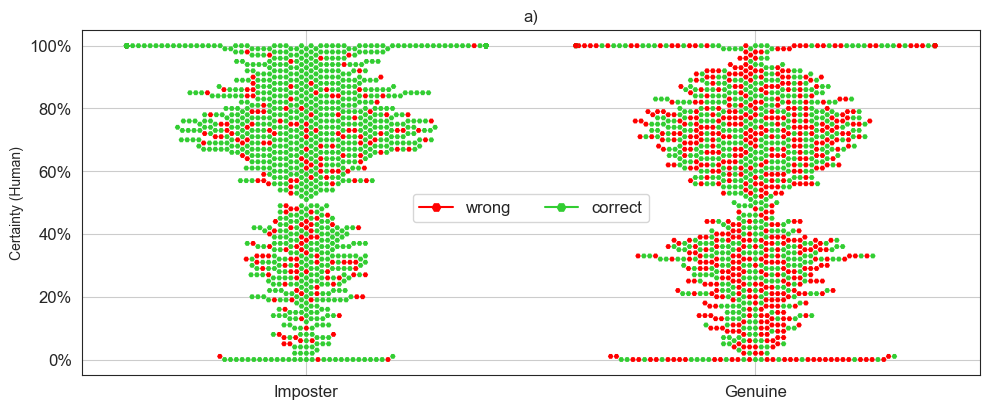

In [80]:
# Make the user stats graphic
sns.set_style("white")
plt.figure(figsize=(10, 4))
ax = sns.swarmplot(
    x="label",
    y="certainty",
    data=df[df.model == "Human"],
    hue="correct",
    dodge=False,
    palette=["red", "limegreen"],
    marker="H",
    size=4,
    alpha=1,
)

handles, labels = ax.get_legend_handles_labels()
markers = [plt.Line2D([0, 0], [0, 0], color=h.get_facecolor(), marker="H") for h in handles]

# Make the y labels as percentages
vals = ax.get_yticks()
ax.set_yticklabels(["{:,.0%}".format(x) for x in vals], fontsize=12)
plt.legend(markers, ["wrong", "correct"], loc="upper center", bbox_to_anchor=(0.5, 0.55), ncol=2, fontsize=12)

# set x label
plt.grid("on")
plt.gca().set_xlabel("")
plt.gca().set_xticklabels(["Imposter", "Genuine"], fontsize=12)
plt.gca().set_ylabel("Certainty (Human)")
plt.tight_layout()

plt.title("a)")

plt.savefig("../figures/base_user_certainty.pdf", bbox_inches="tight")

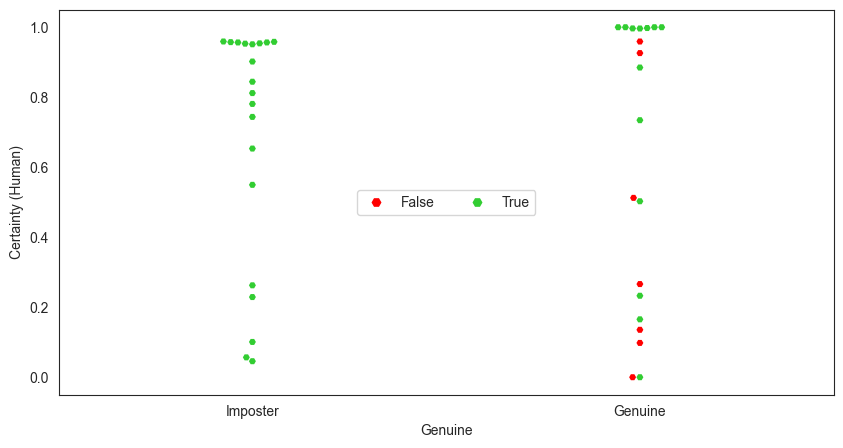

In [84]:
# Swarmplot of Certainty for Models
sns.set_style("white")
plt.figure(figsize=(10, 5))
ax = sns.swarmplot(
    x="label",
    y="certainty",
    data=df[df.model.isin(["FaceTrans", "ArcFace", "ProdPoly"])],
    hue="correct",
    dodge=False,
    palette=["red", "limegreen"],
    marker="H",
)

handles, labels = ax.get_legend_handles_labels()
markers = [plt.Line2D([0, 0], [0, 0], color=h.get_facecolor(), marker="H", linestyle="") for h in handles]
plt.legend(markers, labels, loc="upper center", bbox_to_anchor=(0.5, 0.55), ncol=2)

plt.gca().set_xlabel("Genuine")
plt.gca().set_xticklabels(["Imposter", "Genuine"])
plt.gca().set_ylabel("Certainty (Human)")

plt.savefig("../figures/base_model_certainty.pdf", bbox_inches="tight")

In [85]:
# Ratio of correct ansered pairs depenend on label
print(df.groupby("label").apply(lambda x: len(x[x.correct]) / len(x)).rename("Correct").to_markdown(floatfmt=".2%"))
print("Total Correct: ", len(df[(df.correct)]))
print("Total Answers: ", len(df))

| label   |   Correct |
|:--------|----------:|
| False   |    84.34% |
| True    |    52.50% |
Total Correct:  1861
Total Answers:  2720


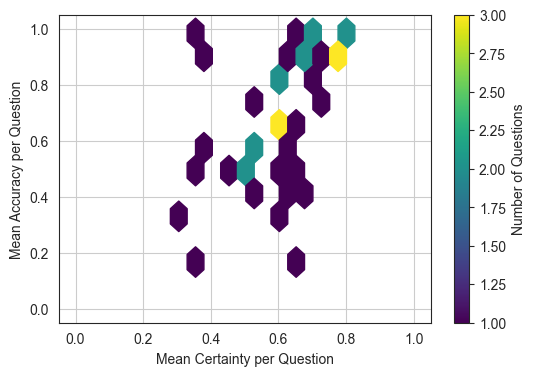

In [98]:
# ACC and CERTAINTY per Pair
x = df[df.model == "Human"].groupby(["pair_id", "dataset", "model"]).mean().certainty.values
y = df[df.model == "Human"].groupby(["pair_id", "dataset", "model"]).mean().correct.values

plt.figure(figsize=(6, 4))
hb = plt.hexbin(x, y, gridsize=10, cmap="viridis", mincnt=1)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid("on")
plt.colorbar(hb, label="Number of Questions")
plt.xlabel("Mean Certainty per Question")
plt.ylabel("Mean Accuracy per Question")

plt.savefig("../figures/hexbin_question_certainty_accuracy.pdf", bbox_inches="tight")

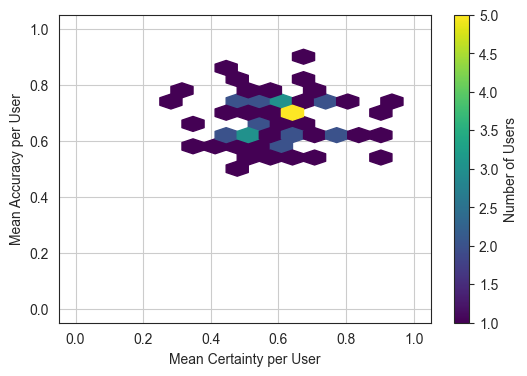

In [99]:
# ACC and CERTAINTY per User
x = df[df.model == "Human"].groupby(["user_id", "dataset", "model"]).mean().certainty.values
y = df[df.model == "Human"].groupby(["user_id", "dataset", "model"]).mean().correct.values

plt.figure(figsize=(6, 4))
hb = plt.hexbin(x, y, gridsize=10, cmap="viridis", mincnt=1)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid("on")
plt.colorbar(hb, label="Number of Users")
plt.xlabel("Mean Certainty per User")
plt.ylabel("Mean Accuracy per User")
plt.savefig("../figures/hexbin_user_certainty_accuracy.pdf", bbox_inches="tight")

|       |   duration |
|:------|-----------:|
| count |    2366.00 |
| mean  |      10.71 |
| std   |       8.38 |
| min   |       1.00 |
| 25%   |       5.00 |
| 50%   |       8.00 |
| 75%   |      13.49 |
| max   |      60.00 |
| prediction   |   Mean |
|:-------------|-------:|
| False        |  10.22 |
| True         |  11.66 |
| prediction   |   Std |
|:-------------|------:|
| False        |  8.12 |
| True         |  8.78 |
t-statistic: 3.99
p-value: 0.00003


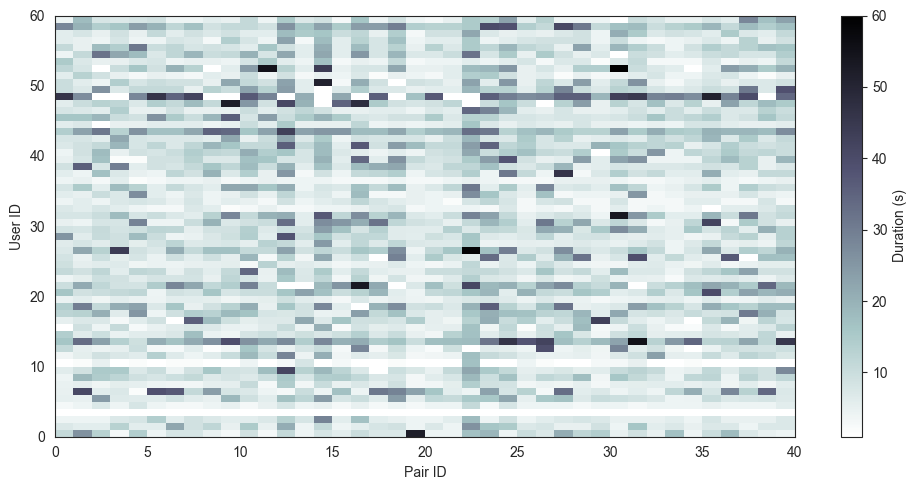

In [120]:
# DURATION of each user and pair according to Prediction

# Create a new dataframe with the duration of each user and pair id
tmp = df[df.model == "Human"].groupby(["user_id", "pair_id"]).apply(lambda x: x.duration.values[0]).reset_index()
tmp.columns = ["user_id", "pair_id", "duration"]

# make a pivot table
tmp = tmp.pivot(index="user_id", columns="pair_id", values="duration")

# plot the colormesh
plt.figure(figsize=(10, 5))
plt.pcolormesh(tmp, cmap="bone_r")
plt.colorbar(label="Duration (s)")
plt.xlabel("Pair ID")
plt.ylabel("User ID")
plt.tight_layout()

plt.savefig("../figures/colormesh_user_duration.pdf", bbox_inches="tight")

dfh = df[df.model == "Human"]

# Calculate mean/std duration
print(dfh.duration.describe().to_markdown(floatfmt=".2f"))

# Calculate mean duration dependend on label
print(dfh.groupby("prediction").apply(lambda x: np.mean(x.duration)).rename("Mean").to_markdown(floatfmt=".2f"))

# Calculate std duration dependend on label
print(dfh.groupby("prediction").apply(lambda x: np.std(x.duration)).rename("Std").to_markdown(floatfmt=".2f"))

# Make t-test for both durations
stat, p_val = stats.ttest_ind(
    dfh[dfh.prediction == 1].duration.values, dfh[dfh.prediction == 0].duration.values, nan_policy="omit", alternative="greater"
)

print(f"t-statistic: {stat:.02f}")
print(f"p-value: {p_val:.05f}")

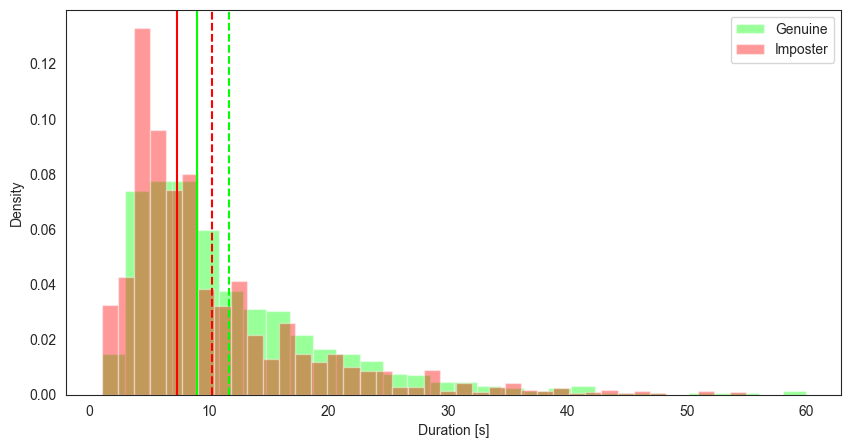

In [121]:
# Plot Duration for label == 1 and label == 0
plt.figure(figsize=(10, 5))
sns.distplot(dfh[dfh.prediction == 1].duration, label="Genuine", kde=False, norm_hist=True, color="lime")
sns.distplot(dfh[dfh.prediction == 0].duration, label="Imposter", kde=False, norm_hist=True, color="red")

# plot means as vertical dashed lines
plt.axvline(dfh[dfh.prediction == 1].duration.mean(), color="lime", linestyle="--")
plt.axvline(dfh[dfh.prediction == 0].duration.mean(), color="red", linestyle="--")

# plot medians as vertical lines
plt.axvline(dfh[dfh.prediction == 1].duration.median(), color="lime", linestyle="-")
plt.axvline(dfh[dfh.prediction == 0].duration.median(), color="red", linestyle="-")

plt.legend()
plt.xlabel("Duration [s]")
plt.ylabel("Density")

plt.savefig("../figures/duration_plot.pdf", bbox_inches="tight")

# Print Median, Mean, Std